In [1]:
import gym, os
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from math import cos
%load_ext autoreload
%autoreload 2

# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [26]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(17, 8)
        self.linear3 = nn.Linear(8, action_size)

    def forward(self, state):
        output = F.relu((self.linear1(state)))
        output = self.linear3(output)
        distribution = F.softmax(output, dim=1)
        return distribution


class Critic(nn.Module):
    def __init__(self, state_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(17, 8)
        self.linear3 = nn.Linear(8, 1)

    def forward(self, state):
        output = F.relu((self.linear1(state)))
        # output = F.relu(self.linear2(output))
        value = self.linear3(output)
        return value

def pick_action(actor, state):
    # state = torch.from_numpy(state).float().unsqueeze(0)
    action_probs = actor(state)
    
    dist = Categorical(action_probs)
    action = dist.sample()

    return action.item(), dist.log_prob(action)

def min_max_scale(state):
    new_state = np.zeros(2)
    new_state[0] = (state[0]+1.2)/(1.8)
    new_state[1] = (state[1]+0.07)/(0.14)
    return new_state


def fourier_basis(curr_state, M=8):
    x = curr_state[0]
    v = curr_state[1]
    v_list = []
    x_list = []
    for i in range(M+1):
        state_func = cos
        x_list.append(state_func(i*x))
        if i > 0:
            v_list.append(state_func(i*np.pi*v))
    phi = x_list + v_list
    phi = np.array(phi) #.reshape(1,-1)
    return phi


Num episodes 0, num actions 4762 True
This is the count 4762 for episode 0
Num episodes 1, num actions 3077 True
This is the count 3077 for episode 1
Num episodes 2, num actions 1999 True
This is the count 1999 for episode 2
Num episodes 3, num actions 1117 True
This is the count 1117 for episode 3
Num episodes 4, num actions 4512 True
This is the count 4512 for episode 4
Num episodes 5, num actions 2249 True
This is the count 2249 for episode 5
Num episodes 6, num actions 1200 True
This is the count 1200 for episode 6
Num episodes 7, num actions 1640 True
This is the count 1640 for episode 7
Num episodes 8, num actions 2185 True
This is the count 2185 for episode 8
Num episodes 9, num actions 1296 True
This is the count 1296 for episode 9
Num episodes 10, num actions 1292 True
This is the count 1292 for episode 10
Num episodes 11, num actions 2001 True
This is the count 2001 for episode 11
Num episodes 12, num actions 2641 True
This is the count 2641 for episode 12
Num episodes 13, nu

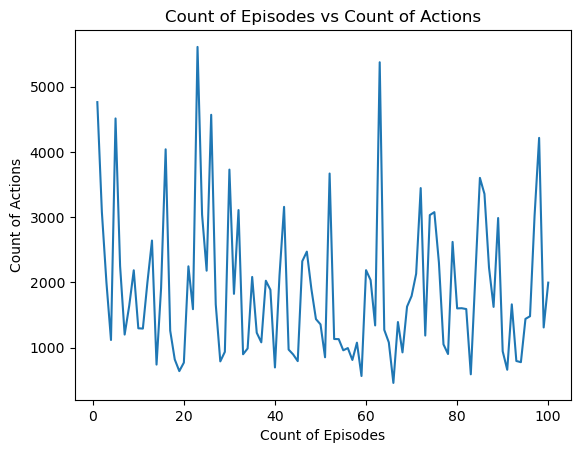

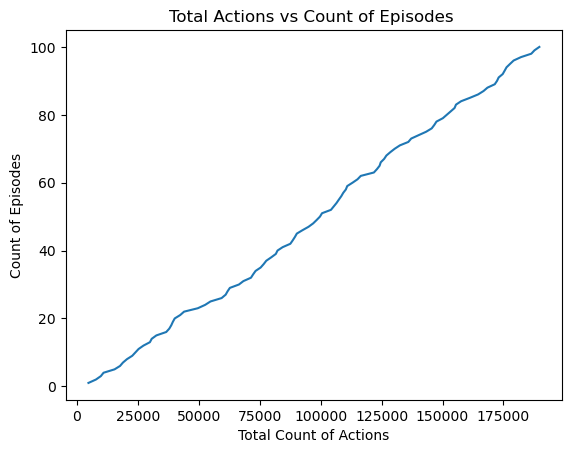

In [29]:
gamma = 0.90
num_episodes = 100
num_steps = 10000
env = gym.make("MountainCar-v0")
# env = gym.envs.make("MountainCarContinuous-v0")

# env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

count_episode = range(1,num_episodes+1)
count_ca = []
count_tca = []
decay_rate = 10


for k in range(1):
    actor = Actor(state_size=state_size, action_size=action_size)
    critic = Critic(state_size)

    
    count_actions = []
    total_count_actions = []
    total_a = 0
    actor_optim = optim.SGD(actor.parameters(),lr=1)
    critic_optim = optim.SGD(critic.parameters(), lr=1)
    decayRate = 0.1
    actor_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=actor_optim, gamma=decayRate)
    critic_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=actor_optim, gamma=decayRate)
    for episode in range(num_episodes):
        
        state = env.reset()
        isTerminal = False
        score = 0
        count_a = 0
        
        # while isTerminal != True:
        for i in range(num_steps): 
            count_a += 1
            
            phi_curr = fourier_basis(min_max_scale(state))    
            state_tensor = torch.from_numpy(phi_curr).float().unsqueeze(0)
            v_curr = critic(state_tensor)
            #Pick action
            action, log_prob = pick_action(actor, state=state_tensor)
            state_prime, reward, isTerminal, info = env.step(action)
            

            phi_next = fourier_basis(min_max_scale(state_prime))
            state_prime_tensor = torch.from_numpy(phi_next).float().unsqueeze(0)
            v_next = critic(state_prime_tensor)

            if state_prime[0] >= 0.5:
                print(f'Num episodes {episode}, num actions {count_a} {isTerminal}')
                v_next = torch.tensor([0]).float().unsqueeze(0)
            # if isTerminal:
            #     print(f'Num episodes {episode}, num actions {i} {isTerminal}')
            
            
            
            # if isTerminal:
            #     v_next = torch.tensor([0]).float().unsqueeze(0)

            # if state_prime[0] >= 0.5:
            #     reward += 1000
            td_target = reward + gamma * v_next
            td_error = reward + gamma*v_next.item()-v_curr.item()
            critic_loss = F.mse_loss(td_target,v_curr)
            actor_loss = -log_prob * td_error
            
            actor_optim.zero_grad()
            actor_loss.backward(retain_graph=True)
            
            if state_prime[0] >= 0.5:
                actor_optim.step()
                actor_lr_scheduler.step()
            
            # print(critic_loss)
            critic_optim.zero_grad()
            critic_loss.backward()
            
            state = state_prime

            # print(f'Actor loss is {actor_loss} and critic loss is {critic_loss}')
            if state_prime[0] >= 0.5:
                critic_optim.step()
                critic_lr_scheduler.step()
                break
            # print(state)
        print(f'This is the count {count_a} for episode {episode}')
        count_actions.append(count_a)
        total_a += count_a
        total_count_actions.append(total_a)
        
    # torch.save(actor, f'actor{k}.pkl')
    # torch.save(critic, f'critic{k}.pkl')
    env.close()
    count_ca.append(count_actions)
    count_tca.append(total_count_actions)


avg_ca = np.array(count_ca)
avg_ca = np.average(count_ca, axis=0)
plt.figure()
plt.title('Count of Episodes vs Count of Actions')
plt.xlabel('Count of Episodes')
plt.ylabel('Count of Actions')
plt.plot(count_episode, avg_ca)
plt.savefig('mc_count_actions_ac.jpg')
plt.show()

avg_tca = np.array(count_tca)
avg_tca = np.average(count_tca, axis=0)
plt.figure()
plt.title('Total Actions vs Count of Episodes ')
plt.ylabel('Count of Episodes')
plt.xlabel('Total Count of Actions')
plt.plot(avg_tca, count_episode)
plt.savefig('mc_total_actions_ac.jpg')
plt.show()

In [31]:
state

array([0.34678385, 0.25450605], dtype=float32)

In [45]:
min_max_scale(state)

array([0.31516414, 0.70109362])

In [91]:
len(fourier_basis(min_max_scale(state)))

17

In [34]:
state

array([0.34678385, 0.25450605], dtype=float32)

In [86]:
import gym
# env = gym.make('MountainCar-v0')
state = env.reset()

while not isTerminal:
    print(state)
    phi_curr = fourier_basis(min_max_scale(state))
    state_tensor = torch.from_numpy(phi_curr).float().unsqueeze(0)
    v_curr = critic(state_tensor)
    #Pick action
    action, log_prob = pick_action(actor, state=state_tensor)
    state_prime, reward, isTerminal, info = env.step(action.item())
    state_prime = torch.FloatTensor(state_prime)
    state = state_prime
    # env.step(env.action_space.sample())
    # env.render('human')

In [87]:
import gym
# env = gym.make('MountainCar-v0')
state = env.reset()

while not isTerminal:
    print(state)
    phi_curr = fourier_basis(min_max_scale(state))
    state_tensor = torch.from_numpy(phi_curr).float().unsqueeze(0)
    v_curr = critic(state_tensor)
    #Pick action
    action, log_prob = pick_action(actor, state=state_tensor)
    state_prime, reward, isTerminal, info = env.step(action.item())
    state_prime = torch.FloatTensor(state_prime)
    state = state_prime
    # env.step(env.action_space.sample())
    # env.render('human')
env.close()